In [ ]:
# lets view kmeans as a latent variable model where z is one-hot descrete latent variable
from torch.distributions.dirichlet import Dirichlet
from torch.nn.functional import one_hot
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class LVKmeans(nn.Module):
    def __init__(self, n_centroids, output_dim, latent_size=400):
        super(LVKmeans, self).__init__()
        self.n_centroids = n_centroids
        self.output_dim = output_dim
        self.latent_size = latent_size
        # decoder is a linear layer
        #output_dim = n_centroids
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, output_dim, bias=False),
        )
        # init z to one-hot descrete latent variable
        self.z = nn.Parameter(
            Dirichlet(torch.ones(n_centroids)).sample((latent_size,)).T
            , requires_grad=True
        )
        self.projector = nn.Sequential(
            nn.Linear(n_centroids, n_centroids *10),
            nn.ReLU(),
            nn.Linear(n_centroids *10, n_centroids *100),
            nn.ReLU(),
            nn.Linear(n_centroids *100, n_centroids *10),
            nn.ReLU(),
            nn.Linear(n_centroids *10, n_centroids),
        )
        self.z_l = None
        self.z_l_fuzzy = None
            
        
    def col_one_hot(self, z):
        # one hot encoding
        #z = torch.argmax(z, dim=0)
        z = torch.argmin(z, dim=0)
        z = one_hot(z, num_classes=self.n_centroids).T
        if self.n_centroids == self.latent_size:
            # make z eye matrix
            z = torch.eye(self.n_centroids)

        return z.float()
    
    def get_z(self):
        return self.z
    
    # sample z from without one-hot encoding
    def sample_z(self, regularize=False):
        if regularize:
            z = self.z
        else:
            z = torch.bernoulli(self.z)
        y = self.decoder(z)
        return y, z

    def forward(self, z):
        z = self.col_one_hot(z)
        # make z dtype float
        y = self.decoder(z)
        self.z_l = y
        # make y fuzzy
        y = y + torch.randn(y.shape)* 1
        self.z_l_fuzzy = y
        y = self.projector(y.T).T
        return y
sq, qp = loadData(100)
sq = torch.from_numpy(sq).float()
sq = squares
# =============================================================================
n_centroids = 4
output_dim = 2
latent_size = 400
model = LVKmeans(n_centroids, output_dim, latent_size=latent_size)
#from ebmUtils import *

# criterion
from src.metrics import Linf_simple
from src.ebmUtils import loss_functional
criterion = Linf_simple
# optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
c2 = nn.MSELoss()
# epochs
epochs = 100
times = 1
p_times = epochs / times
# create times * figures
col = 4
row = int(times / col) + 1
#fig, axs = plt.subplots(row, col, figsize=(10, 10))
# y = torch.tensor(spiral_data, dtype=torch.float32)
y = sq
# input =torch.from_numpy(spiral_data).float()
input = sq
costs = []
best_model = None
best_cost = float('inf')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
costs = []
rem = []
reg = []
rem.append(torch.tensor(1))
p_c = []
p_p = []
p_e = []
reg_let_r = []
reg_cost_r = []
models = []
test = False
z_l =[]
z_l_fuzzy = []
c_l = []
c_l_fuzzy = []
std = []
mu =[]
for epoch in range(epochs):

    # forward
    outputs = model(model.z)

    # add random noise
    c_l.append(outputs)
    if epoch %1000 == 0:
        scale = 100
        std_ = rem[-1].item()/scale
        outputs = outputs + torch.randn_like(outputs)*std_
        std.append(std_)
        mu.append(outputs)
    # calculate cost
    c_l_fuzzy.append(outputs)
    # make outputs numpy
    cost = loss_functional(outputs, y, model)
    c1 = cost
    F, z = cost.min(1)
    rem.append(torch.sum(F))
    cost = torch.mean(F) 
    #cost = torch.sum(F) + reg_cost + reg_let
    if test == True and epoch > 100000:
        cost = c2_cost + reg_cost + reg_let + c3_cost
    reg.append(0)
    # append latents
    z_l.append(model.z_l)
    z_l_fuzzy.append(model.z_l_fuzzy)
    # backward
    optimizer.zero_grad()
    # make sure cost is torch tensor
    costs.append(cost.item())
    #rem.append(cost)
    cost.backward()
    optimizer.step()
    if cost < best_cost:
        best_cost = cost
        best_model = model
        best_outputs = outputs
        best_z = z
        best_lat = model.z_l
        best_epoch = epoch
    if cost < 6000:
        p_p.append(outputs)
        p_c.append(cost)
        p_e.append(epoch)
    # print
    if (epoch + 1) % p_times == 0:
        # print
        print('Epoch [{}/{}], Cost: {:.4f}'.format(epoch + 1, epochs, cost.item()))
        print('Outputs: ', outputs)
# plot outputs
outputs = best_outputs.detach().numpy()
# plot
fig, ax = plt.subplots()
ax.scatter(outputs[:, 0], outputs[:, 1], s=1, c='b')
# plot outputs
ax.scatter(y[:, 0], y[:, 1], s=1, c='r')
# add a plot for costs
fig, ax = plt.subplots()
ax.plot(costs)
plt.show()


print('Best epoch: ', best_epoch)
print('Best cost: ', best_cost)

In [ ]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=3)
# plot
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=1, c='b')
plt.show()
# take points to 0,300
x_min = X[:, 0].min()
y_min = X[:, 1].min()
X[:, 0] -= x_min
X[:, 1] -= y_min
#X = X[:, [0, 2]]
X *= 300 * 0.1
X = np.array(X)
# plot X
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=1, c=y)
args = {
    'X': X,
    'y': y,
    'w_lim': [1,10],
    'theta_lim': [1, 3],
    'numberOfData': 1000
}
data = createSquares(**args)
# plot
fig, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1], s=1, c='b')
print(data.shape)
# plot rectangles
import matplotlib.patches as patches
for i in range(data.shape[0]):
    x = data[i, 0]
    y = data[i, 1]
    w = data[i, 2]
    theta = data[i, 3]
    rect = patches.Rectangle((x, y), w, w, angle=theta, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()

In [ ]:
from src.utils.data import create2moons4squares 
args = {
    'x_lim' : [0, 300],
    'y_lim' : [0, 300],
    'w_lim' : [1, 4],
    'theta_lim' : [1, 2],
    'plot' : True,
    'noise' : 0.1,
    'numberOfData': 200,
    'normalize' : True,
    'scale' : True,
    'scale_factor' : 0.1,
    'numberOfMoons' : 2,
    'which_moon' : 'upper',
}
data = create2moons4squares(**args)

In [ ]:
from sklearn.datasets import make_blobs, make_moons, make_circles, make_s_curve, make_swiss_roll
from src.utils.data import createSquares
import matplotlib.pyplot as plt
import numpy as np
n = 500
#X, y= make_circles(n_samples=1000, noise=0.05, factor=0.5)
#X, y = make_s_curve(n_samples=1000, noise=0.2)
X, y = make_swiss_roll(n_samples=n, noise=0.9)
# plot 2d
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 2], s=1, c=y)
# take points to 0,300
x_min = X[:, 0].min()
y_min = X[:, 2].min()
X[:, 0] -= x_min
X[:, 2] -= y_min
X = X[:, [0, 2]]
X *= 300 * 0.1
#X *= 300 * 0.5
X = np.array(X)
# plot X
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=1, c=y)
args = {
    'X': X,
    'y': y,
    'w_lim': [1,10],
    'theta_lim': [1, 3],
    'numberOfData': n
}
data = createSquares(**args)
# plot
fig, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1], s=1, c='b')
print(data.shape)
# plot rectangles
import matplotlib.patches as patches
for i in range(data.shape[0]):
    x = data[i, 0]
    y = data[i, 1]
    w = data[i, 2]
    theta = data[i, 3]
    rect = patches.Rectangle((x, y), w, w, angle=theta, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()


Loading data...
Data loaded.

Creating student for node 0 that has 100 data, which is more than the threshold 20.
Bounding box for node 0: [[-1, 307], [3, 306]]
Creating teacher for node 0 with 4 centroids.
Training Teacher Model


c:\Users\panagiotis.rigas\Documents\Code\GeoCluster\src\geometry.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rotation = torch.tensor(rotation)


Epoch: 2/60.. 
 Training loss: 200.74925.. 
 torch.mean(F): 197.59338.. 
 Reg Proj: 2.58260.. 
 Reg Latent: 0.00000.. 
 Repulsive: 0.57327.. 
 Memory: 59.27802.. 
 Memory: 59.27802.. 
 Output: 
 [[ 0.9027226  2.13802  ]
 [ 1.7526662  2.9918404]
 [-1.2471746 -1.6849966]
 [-1.0105681 -2.862893 ]]
Epoch: 4/60.. 
 Training loss: 193.23466.. 
 torch.mean(F): 189.82245.. 
 Reg Proj: 3.08477.. 
 Reg Latent: 0.14649.. 
 Repulsive: 0.18096.. 
 Memory: 56.94673.. 
 Memory: 56.94673.. 
 Output: 
 [[ 3.3988297  4.4793844]
 [ 8.31082   12.025    ]
 [-1.1013861 -2.139546 ]
 [-3.749279  -4.4336224]]
Epoch: 6/60.. 
 Training loss: 173.74657.. 
 torch.mean(F): 171.51846.. 
 Reg Proj: 1.99963.. 
 Reg Latent: 0.15213.. 
 Repulsive: 0.07634.. 
 Memory: 51.45554.. 
 Memory: 51.45554.. 
 Output: 
 [[ 7.1785555  12.320437  ]
 [18.435322   39.75501   ]
 [ 2.7950919   0.99522924]
 [-4.3326254  -2.5606842 ]]
Epoch: 8/60.. 
 Training loss: 144.71930.. 
 torch.mean(F): 143.92029.. 
 Reg Proj: 0.59119.. 
 Reg Late

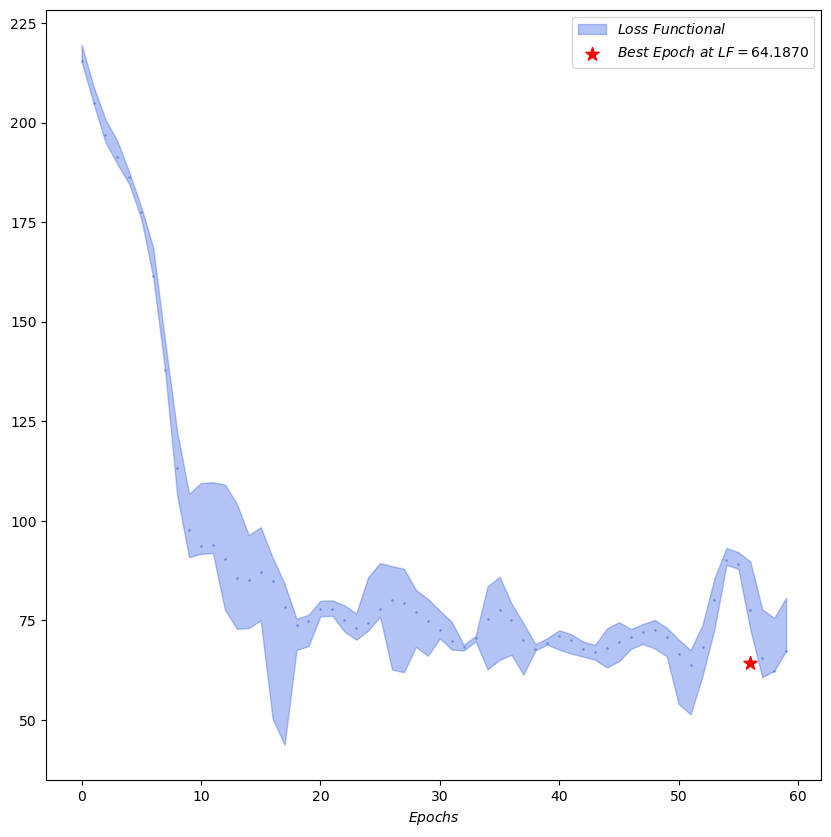

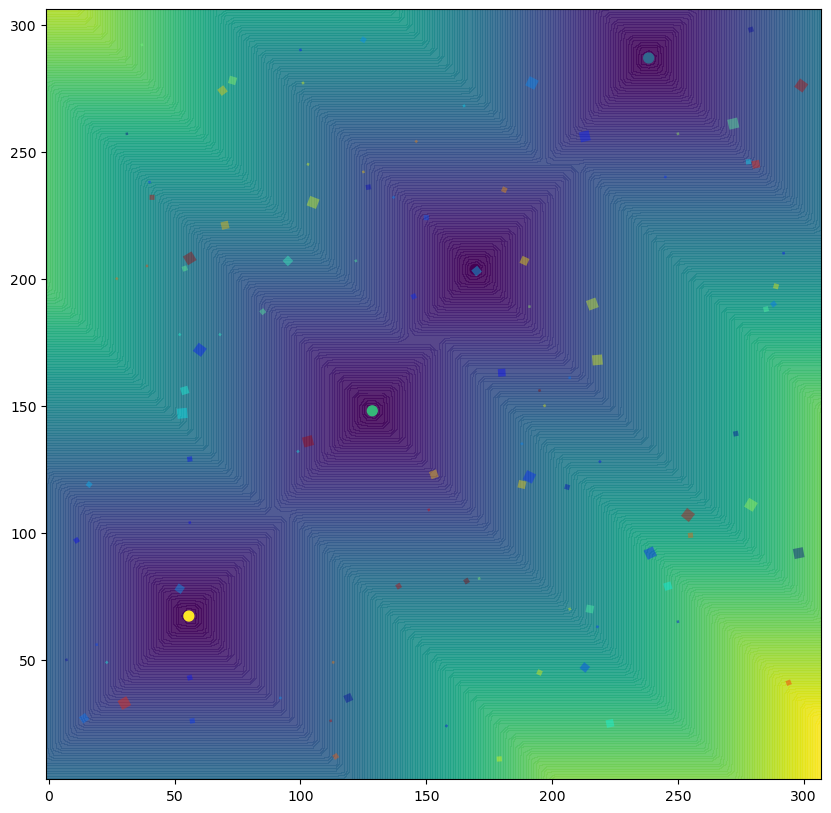

getUncertaintyArea
Ouputs are [[169.38765  203.66037 ]
 [238.3679   286.8408  ]
 [128.53693  148.0027  ]
 [ 55.635124  67.22795 ]]
scale is 308
Processing...
flag is 126
m is 275
i is 400


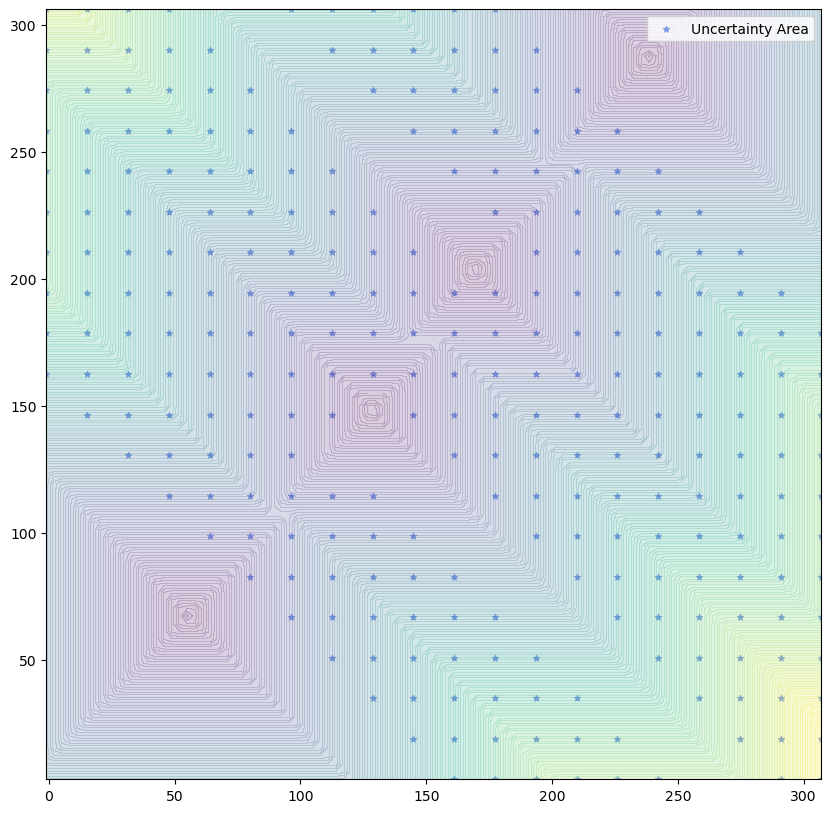

Labeled 0/275 points.
Labeled all 275/275 points.


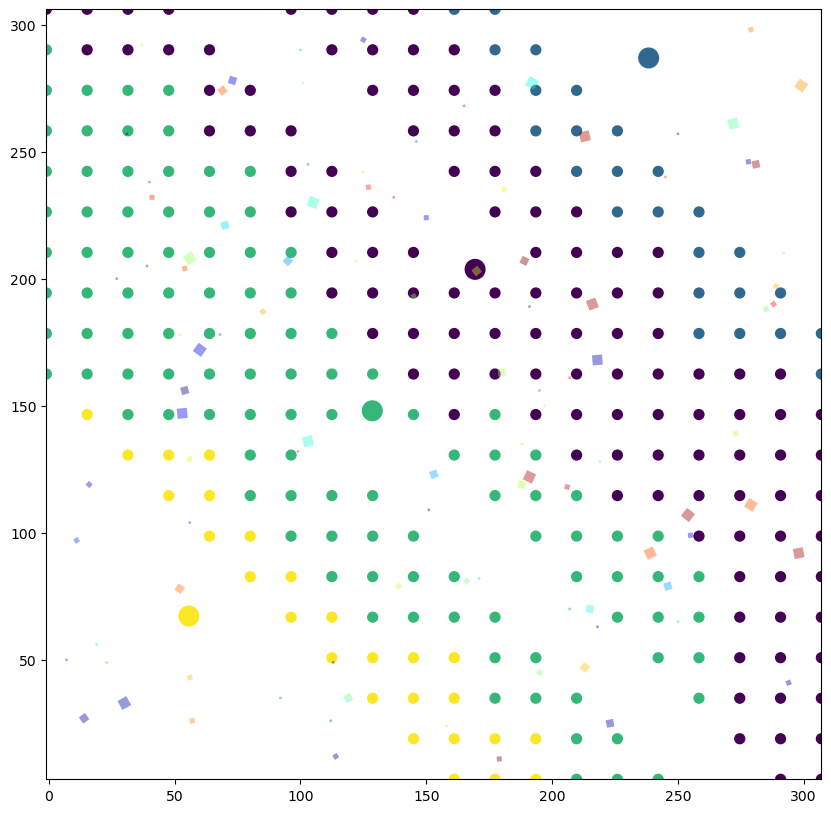

Training Student Model
Acc:  0.09090909090909091
Epoch:  0 Cost:  627.3375244140625
Acc:  0.6763636363636364
Epoch:  100 Cost:  74.61310577392578
Acc:  0.7890909090909091
Epoch:  200 Cost:  52.1139030456543
Acc:  0.8363636363636363
Epoch:  300 Cost:  33.96585464477539
Acc:  0.9381818181818182
Epoch:  400 Cost:  22.277481079101562
Acc:  0.9236363636363636
Epoch:  500 Cost:  27.386554718017578
Acc:  0.9345454545454546
Epoch:  600 Cost:  22.027374267578125
Acc:  0.4727272727272727
Epoch:  700 Cost:  110.86152648925781
Acc:  0.9163636363636364
Epoch:  800 Cost:  28.429264068603516
Acc:  0.8254545454545454
Epoch:  900 Cost:  34.413536071777344
Saved student config to models/squares/100/class0_student_config.pt
Saved teacher training results to models/squares/100/class0_student_training_results.npy


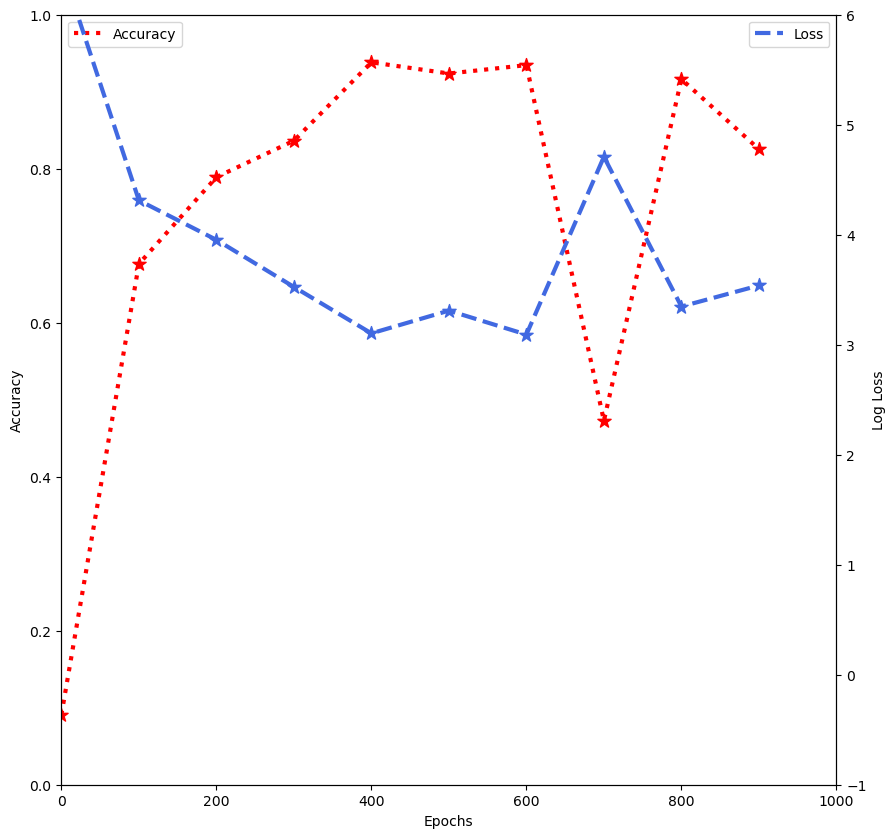


Creating student for node 00 that has 33 data, which is more than the threshold 20.
Bounding box for node 00: [[29, 306], [33, 302]]
Creating teacher for node 00 with 4 centroids.
Training Teacher Model
Epoch: 2/60.. 
 Training loss: 303.64774.. 
 torch.mean(F): 238.65732.. 
 Reg Proj: 64.24363.. 
 Reg Latent: 0.00000.. 
 Repulsive: 0.74680.. 
 Memory: 71.59720.. 
 Memory: 71.59720.. 
 Output: 
 [[-0.6102245  -2.0645943 ]
 [ 0.50546825  1.6012049 ]
 [ 0.16404878  0.7013536 ]
 [ 0.02624153 -0.42939907]]
Epoch: 4/60.. 
 Training loss: 281.58740.. 
 torch.mean(F): 224.24097.. 
 Reg Proj: 57.15388.. 
 Reg Latent: 0.09727.. 
 Repulsive: 0.09530.. 
 Memory: 67.27229.. 
 Memory: 67.27229.. 
 Output: 
 [[-5.866886   -9.803404  ]
 [13.017503   17.420738  ]
 [ 6.8489685   8.62824   ]
 [ 1.6078663  -0.96408975]]
Epoch: 6/60.. 
 Training loss: 248.34183.. 
 torch.mean(F): 203.56227.. 
 Reg Proj: 44.63204.. 
 Reg Latent: 0.09819.. 
 Repulsive: 0.04934.. 
 Memory: 61.06868.. 
 Memory: 61.06868.. 
 

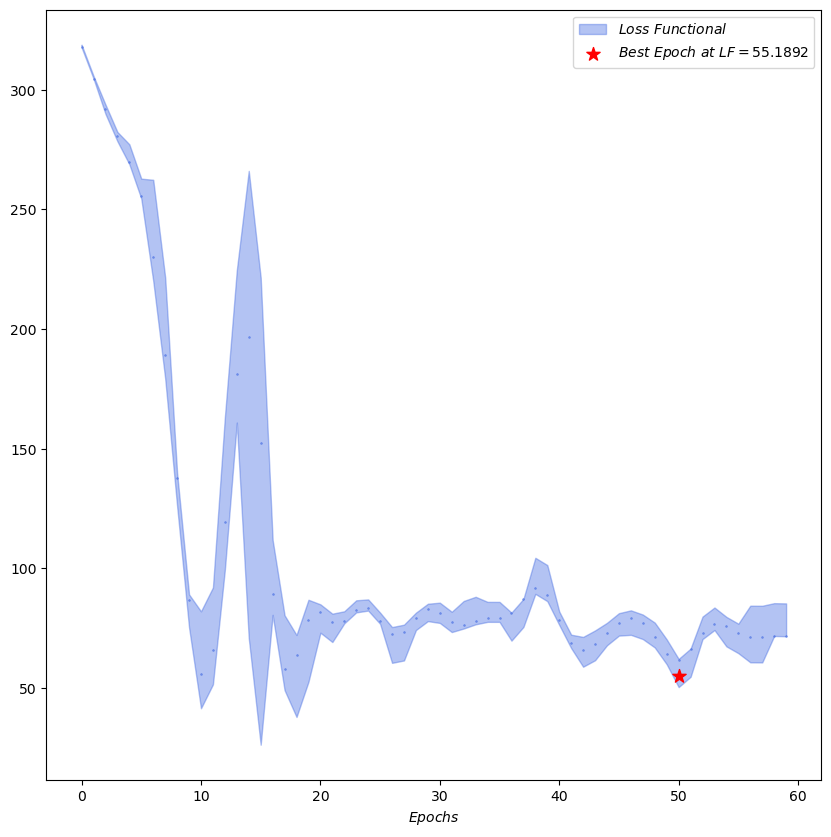

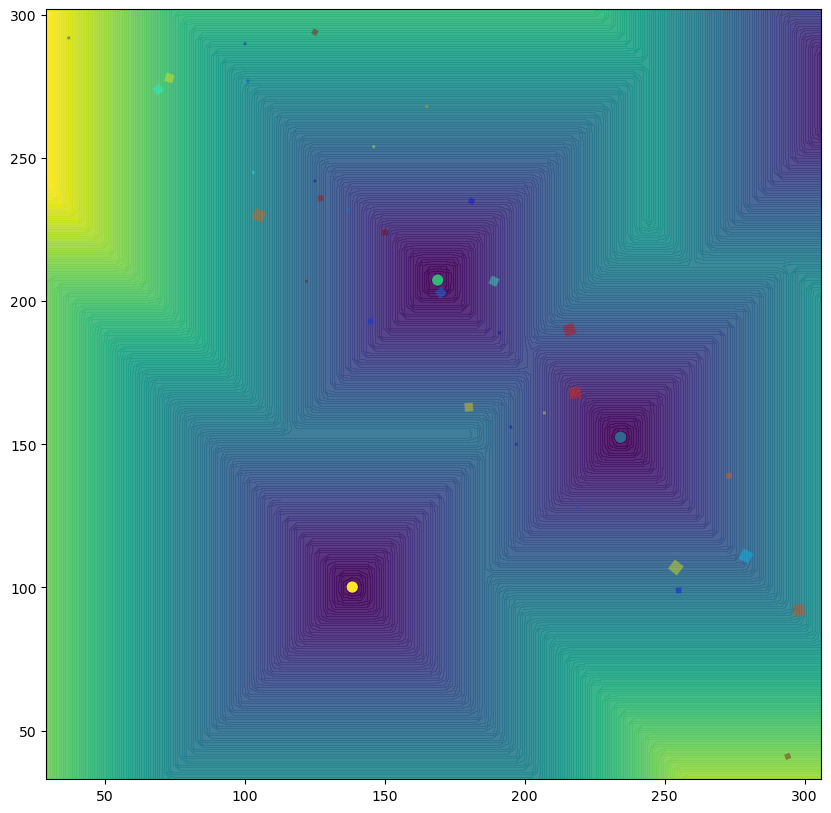

getUncertaintyArea
Ouputs are [[319.6879  272.9271 ]
 [234.21465 152.50046]
 [168.86842 207.3956 ]
 [138.34155 100.16575]]
scale is 277
Processing...
flag is 227
m is 174
i is 400


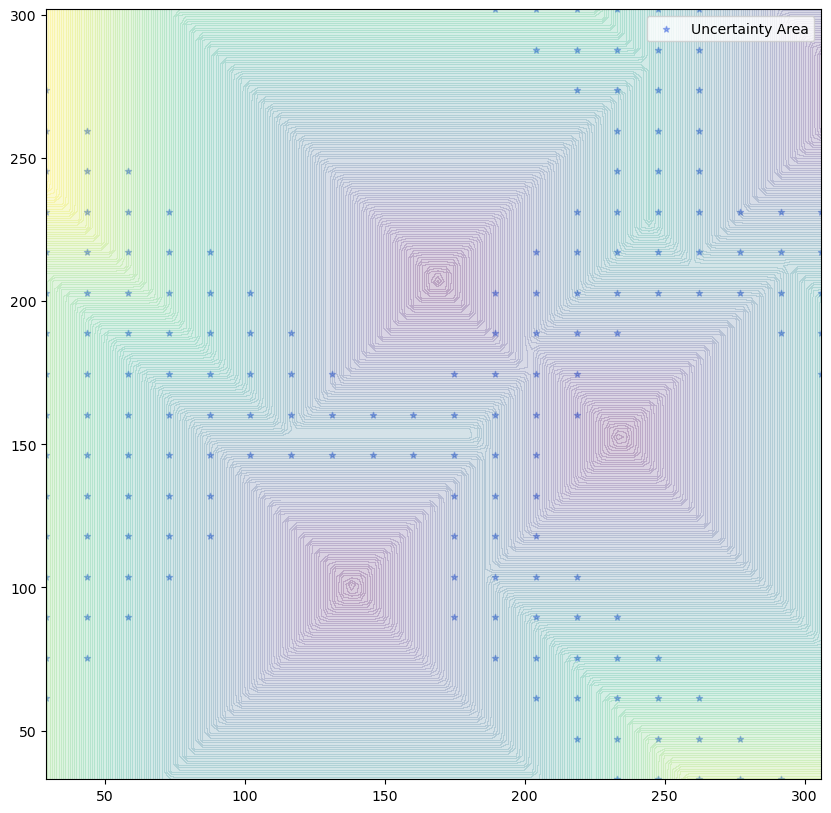

Labeled 0/174 points.
Labeled all 174/174 points.


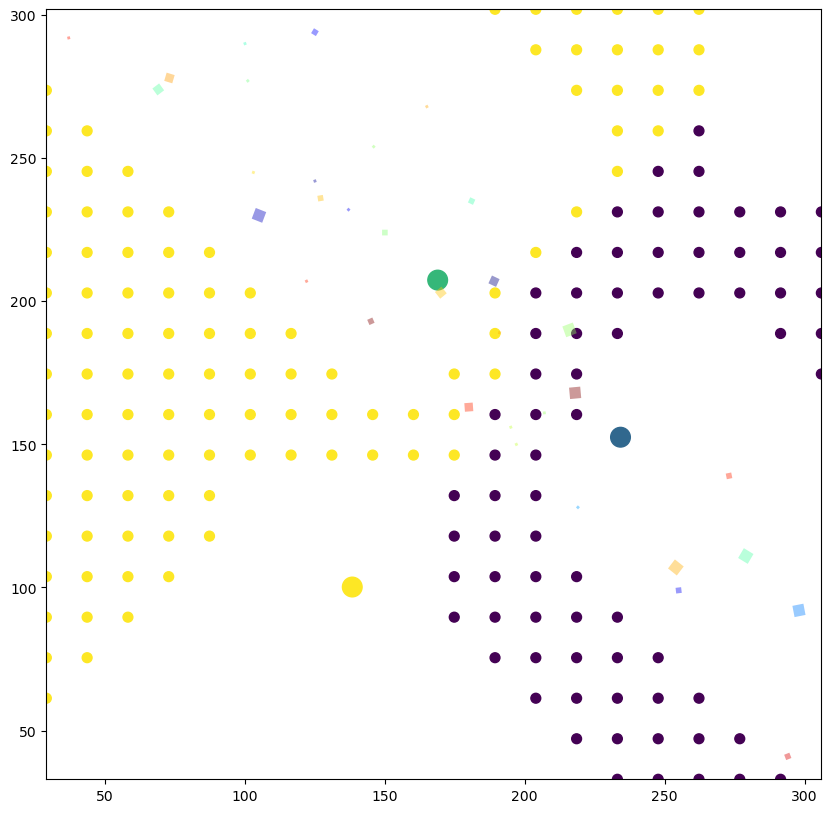

Training Student Model
Acc:  0.4367816091954023
Epoch:  0 Cost:  164.039306640625
Acc:  0.9655172413793104
Epoch:  100 Cost:  7.180638790130615
Acc:  0.9540229885057471
Epoch:  200 Cost:  9.504138946533203
Acc:  0.9712643678160919
Epoch:  300 Cost:  7.567688941955566
Acc:  0.9540229885057471
Epoch:  400 Cost:  7.700117588043213
Acc:  0.9482758620689655
Epoch:  500 Cost:  8.492131233215332
Acc:  0.9712643678160919
Epoch:  600 Cost:  7.166968822479248
Acc:  0.9770114942528736
Epoch:  700 Cost:  7.094179153442383
Acc:  0.9655172413793104
Epoch:  800 Cost:  8.343978881835938
Acc:  0.9655172413793104
Epoch:  900 Cost:  8.119248390197754
Saved student config to models/squares/100/class00_student_config.pt
Saved teacher training results to models/squares/100/class00_student_training_results.npy


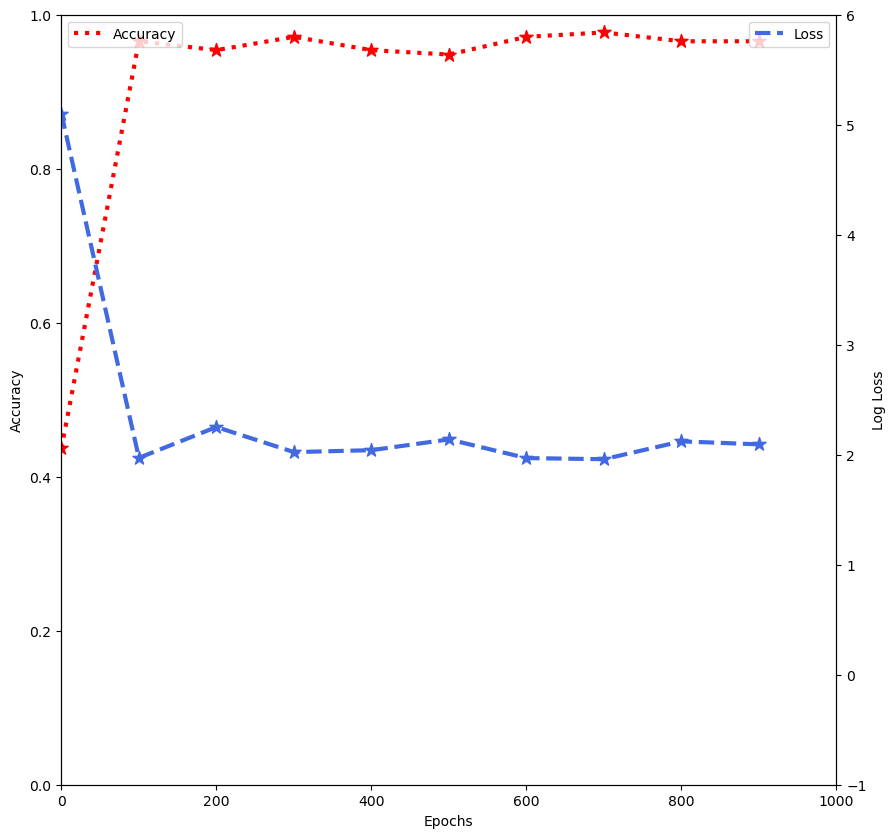


Creating student for node 02 that has 35 data, which is more than the threshold 20.
Bounding box for node 02: [[19, 258], [17, 265]]
Creating teacher for node 02 with 4 centroids.
Training Teacher Model
Epoch: 2/60.. 
 Training loss: 226.23643.. 
 torch.mean(F): 191.16978.. 
 Reg Proj: 34.55244.. 
 Reg Latent: 0.00000.. 
 Repulsive: 0.51421.. 
 Memory: 57.35094.. 
 Memory: 57.35094.. 
 Output: 
 [[ 1.9567527  -0.38668954]
 [-2.8125334  -1.9672656 ]
 [ 1.1332545   0.6752909 ]
 [ 0.11843604  2.402557  ]]
Epoch: 4/60.. 
 Training loss: 214.45354.. 
 torch.mean(F): 183.88481.. 
 Reg Proj: 30.34949.. 
 Reg Latent: 0.10206.. 
 Repulsive: 0.11719.. 
 Memory: 55.16544.. 
 Memory: 55.16544.. 
 Output: 
 [[ 6.242773  -0.5017694]
 [-4.8847165 -7.4041386]
 [ 4.1011257  6.627988 ]
 [ 2.4704747 12.862913 ]]
Epoch: 6/60.. 
 Training loss: 196.29762.. 
 torch.mean(F): 171.76694.. 
 Reg Proj: 24.36849.. 
 Reg Latent: 0.10403.. 
 Repulsive: 0.05815.. 
 Memory: 51.53008.. 
 Memory: 51.53008.. 
 Output: 

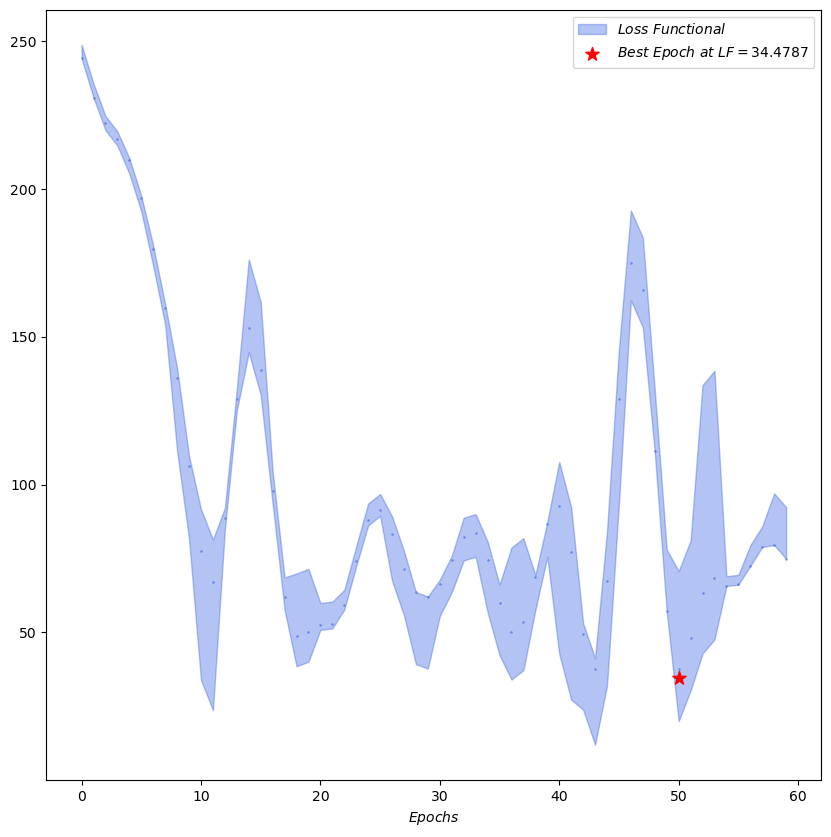

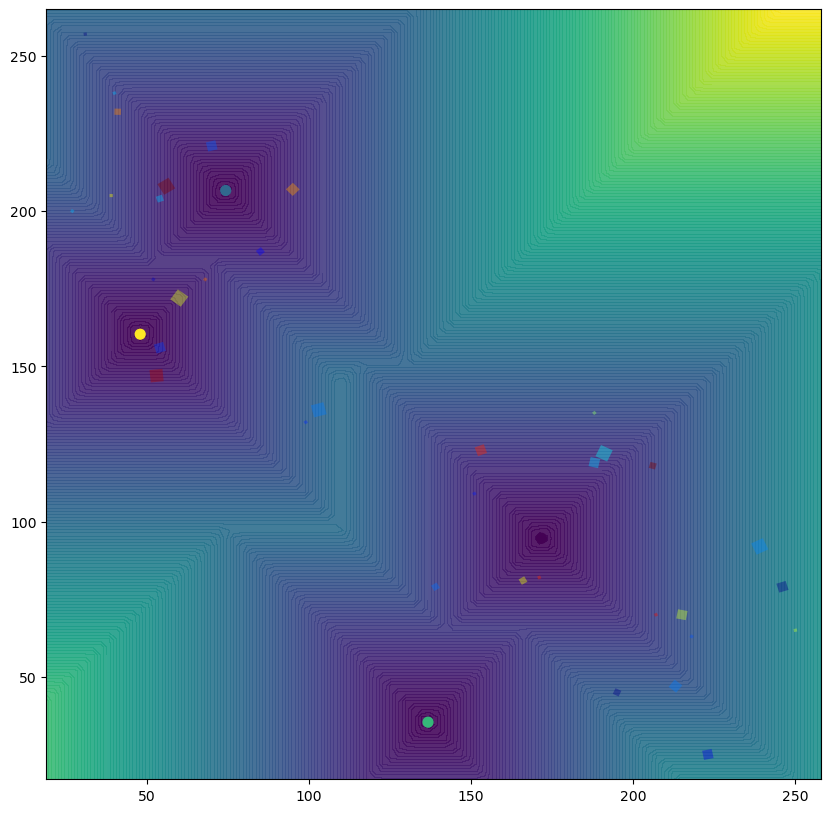

getUncertaintyArea
Ouputs are [[171.69724   94.61206 ]
 [ 74.315796 206.64746 ]
 [136.70479   35.3924  ]
 [ 47.937645 160.3506  ]]
scale is 248
Processing...
flag is 191
m is 210
i is 400


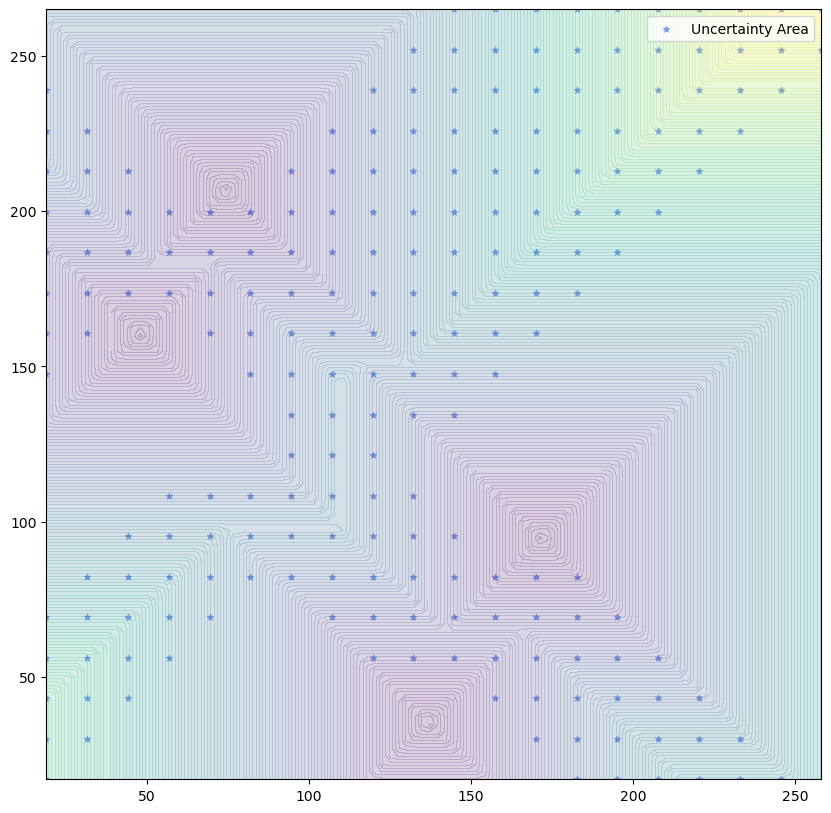

Labeled 0/210 points.
Labeled all 210/210 points.


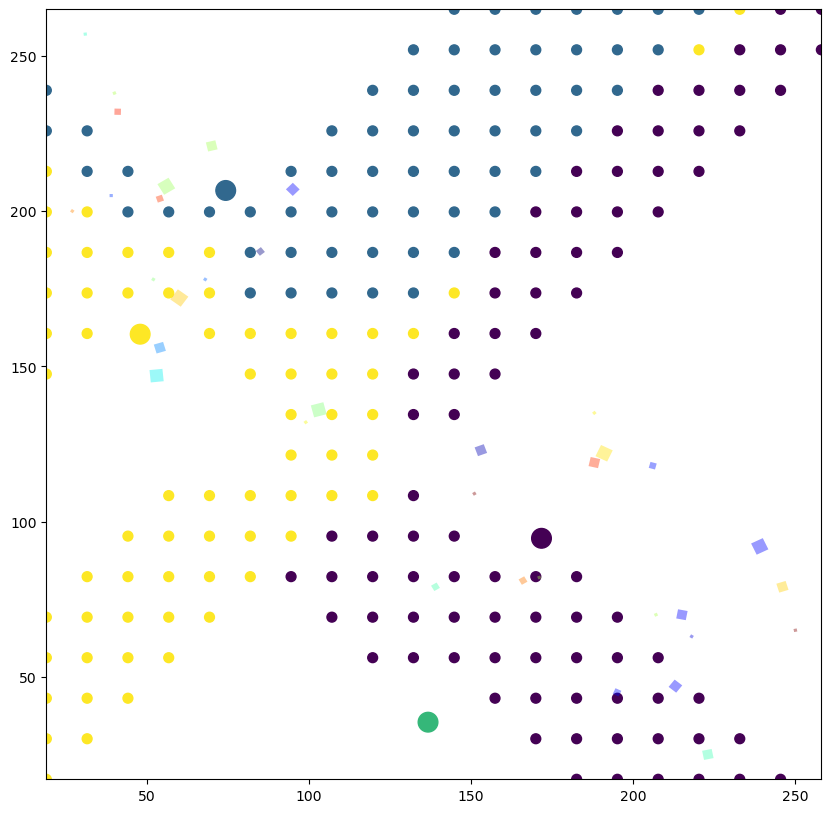

Training Student Model
Acc:  0.0
Epoch:  0 Cost:  208.6474609375
Acc:  0.8761904761904762
Epoch:  100 Cost:  30.97333526611328
Acc:  0.9285714285714286
Epoch:  200 Cost:  22.503681182861328
Acc:  0.9333333333333333
Epoch:  300 Cost:  14.408792495727539
Acc:  0.9761904761904762
Epoch:  400 Cost:  11.029459953308105
Acc:  0.9761904761904762
Epoch:  500 Cost:  10.290287017822266
Acc:  0.9761904761904762
Epoch:  600 Cost:  6.073897838592529
Acc:  0.9666666666666667
Epoch:  700 Cost:  7.142449855804443
Acc:  0.9904761904761905
Epoch:  800 Cost:  7.547571659088135
Acc:  0.919047619047619
Epoch:  900 Cost:  22.02802085876465
Saved student config to models/squares/100/class02_student_config.pt
Saved teacher training results to models/squares/100/class02_student_training_results.npy


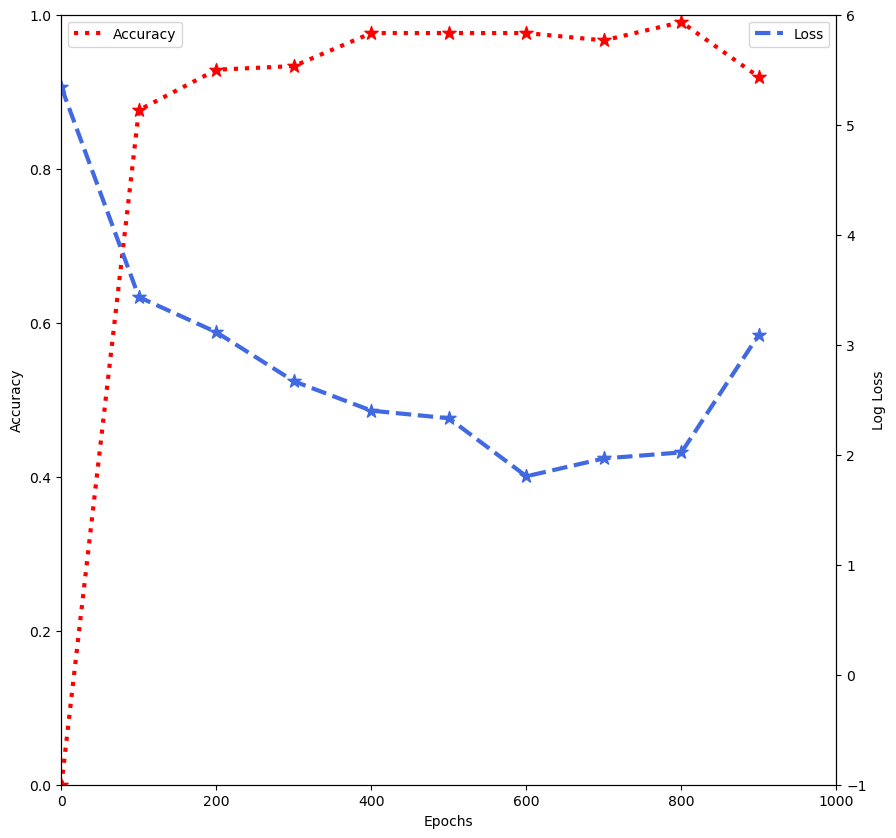


Creating student for node 002 that has 21 data, which is more than the threshold 20.
Bounding box for node 002: [[29, 199], [155, 302]]
Creating teacher for node 002 with 4 centroids.
Training Teacher Model
Epoch: 2/60.. 
 Training loss: 403.43082.. 
 torch.mean(F): 238.89481.. 
 Reg Proj: 161.66692.. 
 Reg Latent: 0.00000.. 
 Repulsive: 2.86911.. 
 Memory: 71.66844.. 
 Memory: 71.66844.. 
 Output: 
 [[-2.2378168  -0.7709588 ]
 [ 0.43178087  0.1985776 ]
 [ 1.0768515   0.34476945]
 [ 1.1723131   0.413813  ]]
Epoch: 4/60.. 
 Training loss: 386.98471.. 
 torch.mean(F): 228.05492.. 
 Reg Proj: 158.75599.. 
 Reg Latent: 0.07051.. 
 Repulsive: 0.10329.. 
 Memory: 68.41647.. 
 Memory: 68.41647.. 
 Output: 
 [[-11.648891    -7.6635613 ]
 [  5.776086     0.85134566]
 [ -0.46562225  -0.09198698]
 [ 13.382694    11.133283  ]]
Epoch: 6/60.. 
 Training loss: 353.34799.. 
 torch.mean(F): 203.11887.. 
 Reg Proj: 150.10146.. 
 Reg Latent: 0.07346.. 
 Repulsive: 0.05420.. 
 Memory: 60.93566.. 
 Memory

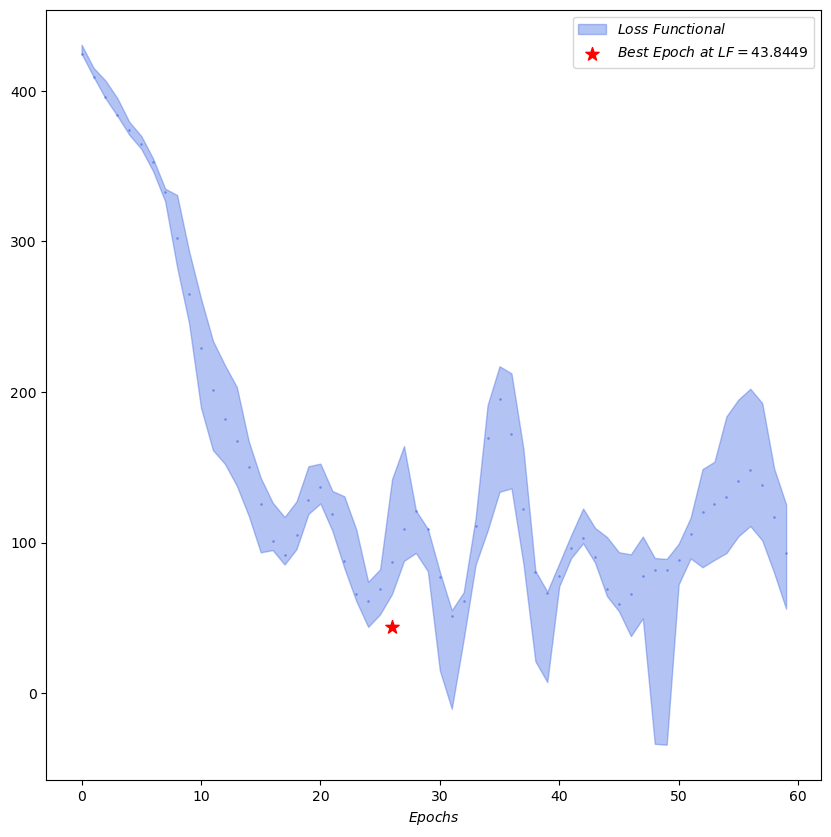

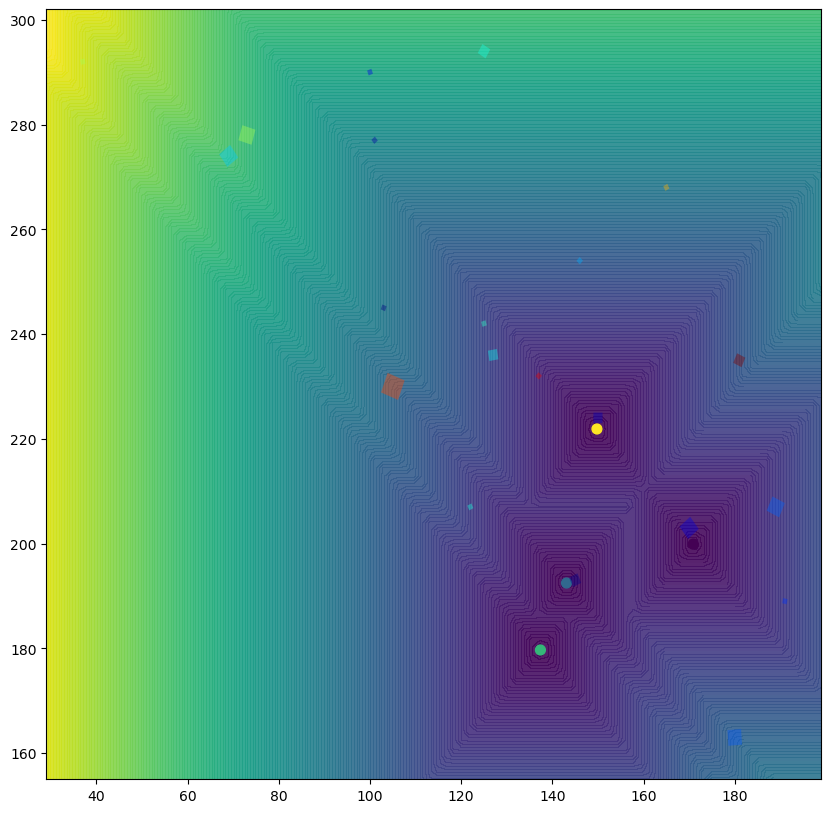

getUncertaintyArea
Ouputs are [[170.90558 199.88913]
 [143.10051 192.46812]
 [137.3793  179.68698]
 [149.77325 221.874  ]]
scale is 170
Processing...
flag is 1
m is 400
i is 400


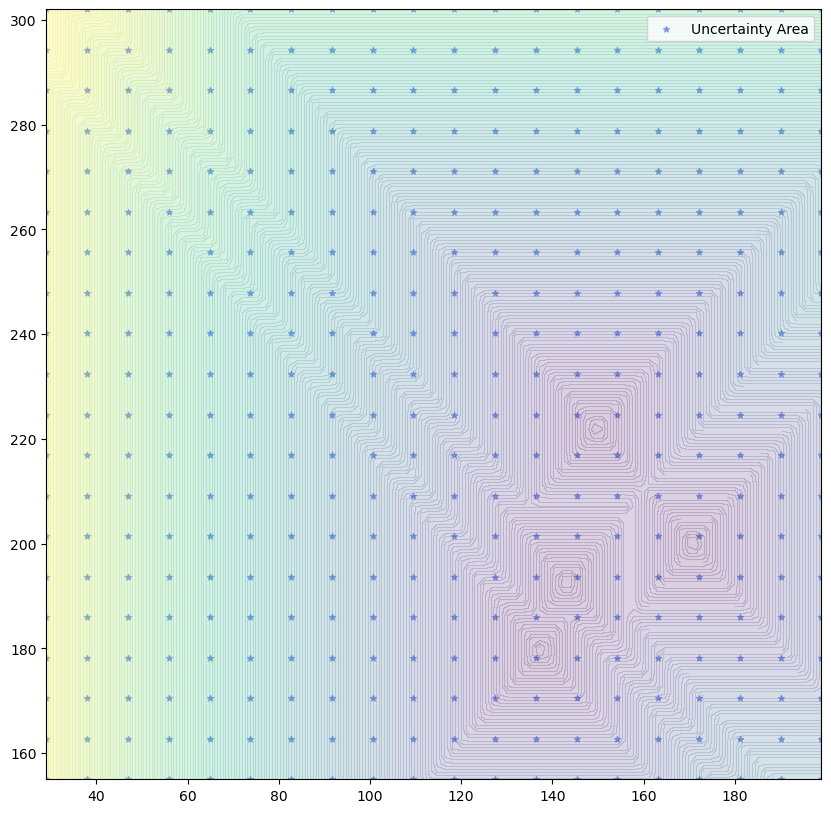

Labeled 0/400 points.
Labeled all 400/400 points.


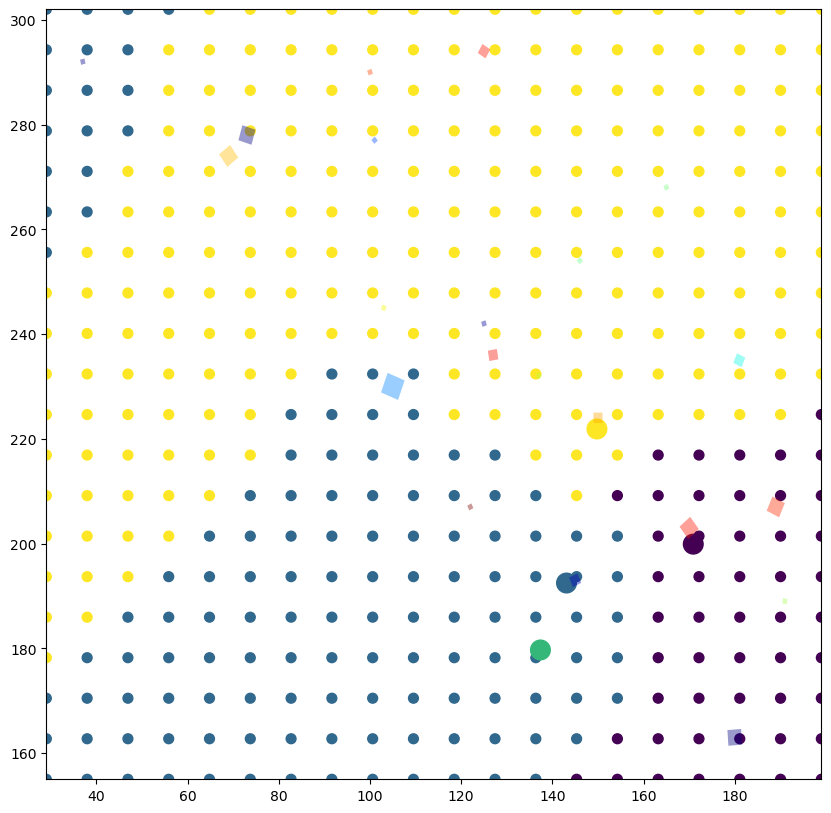

Training Student Model
Acc:  0.23
Epoch:  0 Cost:  170.33872985839844
Acc:  0.6475
Epoch:  100 Cost:  112.03284454345703
Acc:  0.805
Epoch:  200 Cost:  43.645042419433594
Acc:  0.905
Epoch:  300 Cost:  23.91575050354004
Acc:  0.915
Epoch:  400 Cost:  18.770919799804688
Acc:  0.9225
Epoch:  500 Cost:  16.445369720458984
Acc:  0.89
Epoch:  600 Cost:  22.070528030395508
Acc:  0.93
Epoch:  700 Cost:  16.122953414916992
Acc:  0.9625
Epoch:  800 Cost:  11.257428169250488
Acc:  0.8125
Epoch:  900 Cost:  42.684635162353516
Saved student config to models/squares/100/class002_student_config.pt
Saved teacher training results to models/squares/100/class002_student_training_results.npy


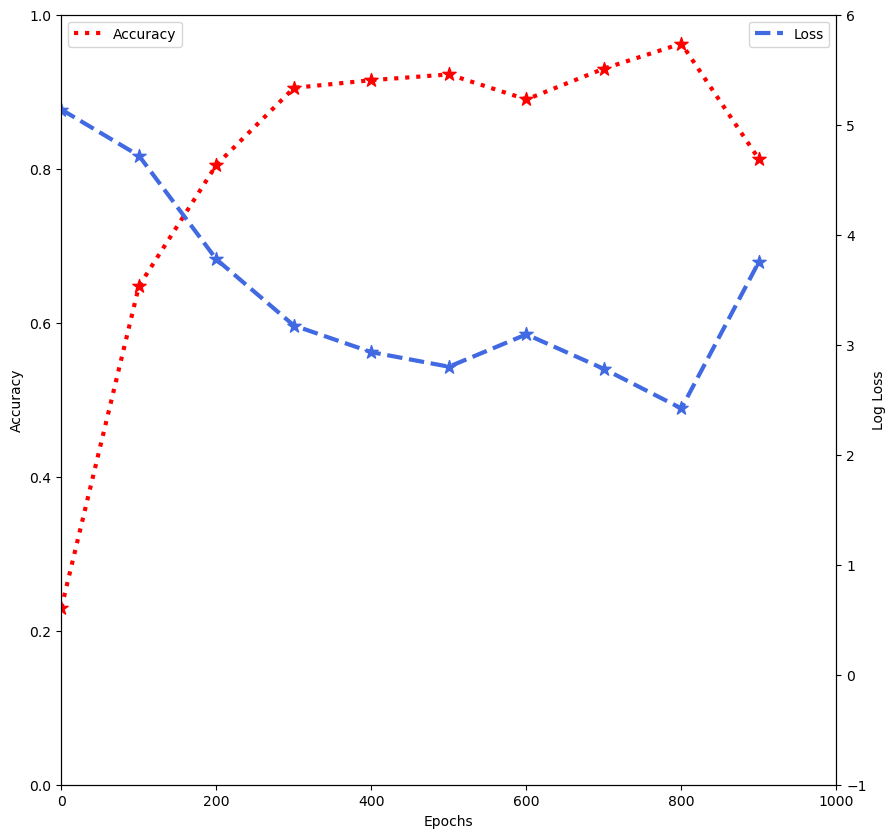

In [1]:
import torch
from src.k_tree import Ktree
from src.utils.data import loadData

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
data, _ = loadData(100)
#data = squares


#data = rects
learning_rate = 5e-3 # 1e-2, 5e-3
k = 4
teacher_args = {
    "optimizer_lr": learning_rate,
    "epochs": 60, # 300
    "times": 30,
    "alpha": 0.1, #  projection loss 0.1
    "beta": 0.1, # latent loss 0.1
    "gamma": 0.1, # repulsive loss 0.01
    "delta": 0.3, # fuzzy scale 0.01
    "f_clk": 10, # 20
    "scale": 1, # fuzzy scale 
    "scale_flag": False,
    "number_of_centroids": k,
    "latent_size": 100,
    "encoder_activation": False,
    "encoder_depth": 3,
    "predictor_width": 5*100,
    "predictor_depth": 3,
}
n = 20
un_args = {
    "N": n,
    "M": n**2-1, # 10000 - 1
    "epsilon": 0.14 # here a layer value should be somehow included. As layers get denser  epilson should be smaller
}
student_args = {
    "optimizer_lr": 5e-3,
    "epochs": 1000, # 30000, 2000
    "width": 200,
    "depth": 5,
}

stop_criterion = 0.1*len(data) if len(data) > 200 else  0.2*len(data) 
#thresshold = 90
thresshold = stop_criterion
thresshold = 20
from src.metrics import Linf_simple
metric = Linf_simple
ktree = Ktree(thresshold, data, metric,teacher_args, un_args, student_args)
ktree.create_tree(save_path_prefix="models/squares/100/class", plot=True)
#path ='./models/squares/100/class_student_config.pt'
#ktree.root.create_student_from_config(path)

In [ ]:
# show limits
lim_X = [data[:, 0].min(), data[:, 0].max()]
lim_Y = [data[:, 1].min(), data[:, 1].max()]
print(lim_X,lim_Y)
# get area
s = (lim_X[1] - lim_X[0]) *(lim_Y[1] - lim_Y[0]) 
# show area
print(s)
ball = 0.93 * np.sqrt(10000000*2)
ball *= 100 * np.sqrt(10)
print(4*ball**2/s)

torch.Size([100, 2])
Query point 0
[ 99.         132.           1.           0.62565621]
[14.         27.          3.          0.63457281]
Wrong prediction for tensor([[ 7., 11.]])
Predicted [ 99.         132.           1.           0.62565621]
Brute force [14.         27.          3.          0.63457281]
Query point 1
[ 99.         132.           1.           0.62565621]
[ 7.         50.          1.          0.37365135]
Wrong prediction for tensor([[ 7.0000, 42.8889]])
Predicted [ 99.         132.           1.           0.62565621]
Brute force [ 7.         50.          1.          0.37365135]
Query point 2
[5.30000000e+01 1.47000000e+02 4.00000000e+00 9.80647761e-02]
[19.         56.          1.          0.23194531]
Wrong prediction for tensor([[ 7.0000, 74.7778]])
Predicted [5.30000000e+01 1.47000000e+02 4.00000000e+00 9.80647761e-02]
Brute force [19.         56.          1.          0.23194531]
Query point 3
[122.         207.           1.           0.44867184]
[11.         97.     

C:\Users\panagiotis.rigas\AppData\Local\Temp\ipykernel_9260\2034732081.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_point = torch.tensor(query_point)


[3.70000000e+01 2.92000000e+02 1.00000000e+00 2.36012914e-01]
[3.10000000e+01 2.57000000e+02 1.00000000e+00 1.22144336e-01]
Wrong prediction for tensor([[  7.0000, 266.1111]])
Predicted [3.70000000e+01 2.92000000e+02 1.00000000e+00 2.36012914e-01]
Brute force [3.10000000e+01 2.57000000e+02 1.00000000e+00 1.22144336e-01]
Query point 9
[3.70000000e+01 2.92000000e+02 1.00000000e+00 2.36012914e-01]
[3.70000000e+01 2.92000000e+02 1.00000000e+00 2.36012914e-01]
Query point 10
[139.          79.           2.           0.53729559]
[57.         26.          2.          0.16510919]
Wrong prediction for tensor([[39.4444, 11.0000]])
Predicted [139.          79.           2.           0.53729559]
Brute force [57.         26.          2.          0.16510919]
Query point 11
[ 99.         132.           1.           0.62565621]
[30.         33.          4.          0.50623807]
Wrong prediction for tensor([[39.4444, 42.8889]])
Predicted [ 99.         132.           1.           0.62565621]
Brute force 

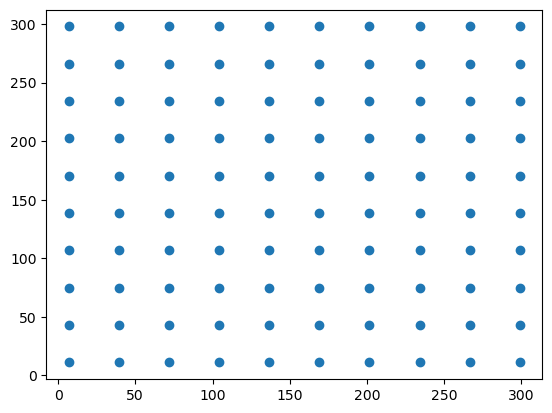

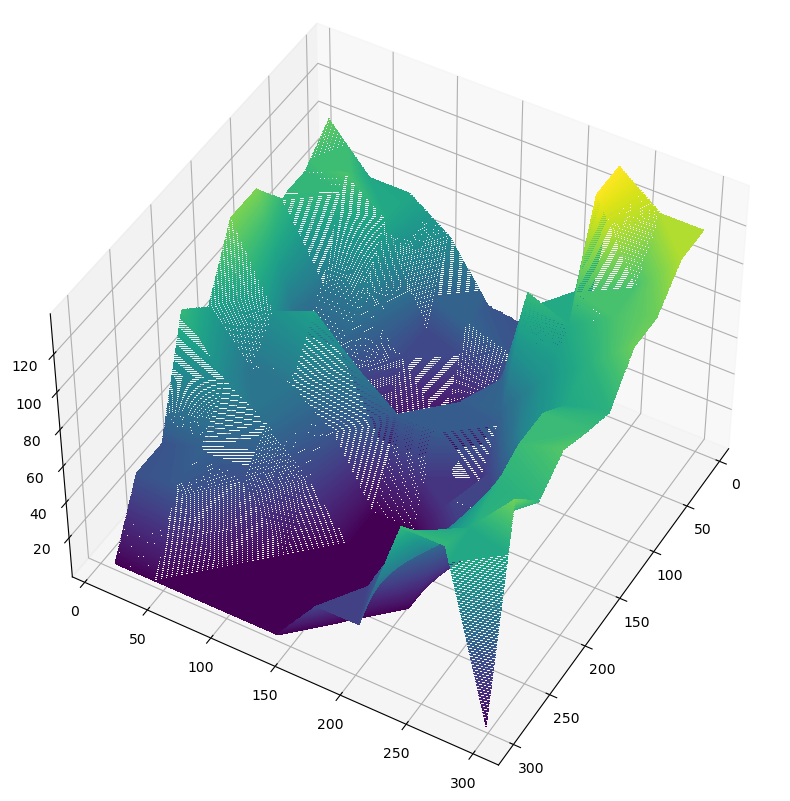

In [4]:
import numpy as np
import matplotlib.pyplot as plt
choice = 2# 0 for regular, 1 for maxsum 
acc = 0
mean_acc = 0
times=0
print_flag = True
random = False
out_of_dist =  False
out_of_manifold = True
#ball =  80
x_lim = min(data[:,0]), max(data[:,0])
y_lim = min(data[:,1]), max(data[:,1])
best_acc = 0
worst_acc = 100
np.random.seed(0)
while times < 1:
    # now lets create randomly N points in the space 0-300, 0-300
    # [[-6, 257], [-6, 179]]
    n = 10**2
    if random:
        # do seed for reproducability 
        random_p = torch.zeros(n, 2)
        for i in range(n):
            random_p[i] = torch.Tensor([np.random.randint(x_lim[0],x_lim[1]), np.random.randint(y_lim[0],y_lim[1])])
        infer_points = random_p.to(device)
    else:
        nop =  n
        random_p = torch.zeros(nop, 2)
        #x_lim = [0,300]
        #y_lim = [0,300]
        num = int(np.sqrt(nop))
        for i, x in enumerate(np.linspace(x_lim[0],x_lim[1], num)):
            for j, y in enumerate(np.linspace(y_lim[0],y_lim[1], num)):
                random_p[i*num+j] = torch.Tensor([x, y])

        infer_points = random_p.to(device)
        print(infer_points.shape)
        plt.scatter(infer_points[:,0], infer_points[:,1])

    if out_of_dist and out_of_manifold:
        # plot points outside 0,300
        x_lim = [x_lim[0]-ball, x_lim[1]+ball]
        y_lim = [y_lim[0]-ball, y_lim[1]+ball]
        num = int(np.sqrt(nop))
        for i, x in enumerate(np.linspace(x_lim[0],x_lim[1], num)):
            for j, y in enumerate(np.linspace(y_lim[0],y_lim[1], num)):
                random_p[i*num+j] = torch.Tensor([x, y])
        infer_points = random_p.to(device)
        print(infer_points.shape)
        plt.scatter(infer_points[:,0], infer_points[:,1])
    num_of_correct_predictions = 0
    qp = infer_points
    z_wrong = np.zeros(len(qp))
    z_label_wrong = np.zeros(len(qp))
    #qp = torch.tensor(qp)
    for i in range(len(qp)-1):
        print("="*20)
        print(f"Query point {i}")
        if choice == 0:
            query_point = qp[i]
            query_point = torch.tensor(query_point)
            pred = ktree.query(query_point)
            brute_force = ktree.root.query(query_point)
            print(pred)
            print(brute_force)
        if choice ==1:
            query_point = qp[i:i+1]
            query_point = torch.tensor(query_point)
            pred = ktree.query_maxsum(query_point)[0]
            brute_force = ktree.root.query(query_point[0])
            print(pred)
            print(brute_force)
        if choice ==2:
            query_point = qp[i:i+1]
            query_point = torch.tensor(query_point)
            pred = ktree.query_maxcumsum(query_point)[0]
            brute_force = ktree.root.query(query_point[0])
            print(pred)
            print(brute_force)
        # print(pred)
        # print(brute_force)
        if(np.array_equal(pred, brute_force)):
            num_of_correct_predictions += 1
        else:
            z_wrong[i] = max(abs(pred[:2]-brute_force[:2]))
            if z_wrong[i] > 0.1:
                z_label_wrong[i] = 1

            if print_flag:
                print("="*20)
                print(f"Wrong prediction for {query_point}")
                print(f"Predicted {pred}")
                print(f"Brute force {brute_force}")
                print("="*20)
                # reshape z_wong to be a 2d array
    axis = int(np.sqrt(len(qp)))
    # make contour of the z_wrong
    x = np.linspace(x_lim[0],x_lim[1], axis)                                        
    y = np.linspace(y_lim[0],y_lim[1], axis)
    X, Y = np.meshgrid(x, y)
    Z = z_wrong.reshape(X.shape)
    if out_of_dist and out_of_manifold:
        # make 0 in Z all values between 0,300, 0,300
        # first find index in X 
        #x_index = np.where((X>=x_lim[0]+ball) & (X<= x_lim[1]-ball))
        x_index = np.where((X>=x_lim[0]+ball) & (X<= x_lim[1]-ball))
        # now make Z 0 in these indexes
        Z[x_index] = 0
        
    # make 3d plot
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.contourf(X, Y, Z, 200, cmap='viridis')
    # rotate
    ax.view_init(45, 30)
    acc = num_of_correct_predictions / len(infer_points) * 100
    if acc > best_acc:
        best_acc = acc
    if acc < worst_acc:
        worst_acc = acc

    mean_acc += acc
    times += 1

    print(f"The percentage of correct predictions is {acc:.2f}%")

print(f"The best percentage of correct predictions is {best_acc:.2f}%")
print(f"The mean percentage of correct predictions is {mean_acc/times:.2f}%")
print(f"The worst percentage of correct predictions is {worst_acc:.2f}%")

In [33]:
#ktree.root.children[-1].children[1].query(infer_point)
ktree.root.children[2].student(infer_point)
ktree.root.children[].student(infer_point)


tensor([ -38.9093,  -69.1159, -157.6136,   91.5925], grad_fn=<AddBackward0>)

In [15]:
infer_point = infer_points[64]
pred = ktree.query(infer_point)
bf = ktree.root.query(infer_point)
print(pred)
print(bf)

Predictions for node 0 are tensor([-17.4927,  -0.1239,   1.7707,   4.1283], grad_fn=<AddBackward0>)
Predictions for node 03 are tensor([ -5.1828,   5.8064,   5.9571, -22.9679], grad_fn=<AddBackward0>)
Query point tensor([201.6667, 138.5556]) belongs to node 032 
[188.         135.           1.           0.68027295]
[197.         150.           1.           0.44867184]


In [ ]:
len(ktree.get_leaves())

In [ ]:
query_point

In [ ]:
infer_points[0:1]

In [ ]:
ktree.query(infer_points)

In [ ]:
n = 100
random_p = torch.zeros(n, 2)
for i in range(n):
    random_p[i] = torch.Tensor([np.random.randint(x_lim[0],x_lim[1]), np.random.randint(y_lim[0],y_lim[1])])
infer_points = random_p
print(infer_points.shape)
r = ktree.query_maxsum(query_point)
r[0]

In [ ]:
# flags
wanna_plot_square = True
# do a 2d contour
fig, ax = plt.subplots()
axis = int(np.sqrt(len(qp)))

for i, x in enumerate(np.linspace(x_lim[0],x_lim[1], axis)):
    for j, y in enumerate(np.linspace(y_lim[0],y_lim[1], axis)):
        random_p[i*axis+j] = torch.Tensor([x, y])
infer_points = random_p.to(device)
y = np.linspace(y_lim[0],y_lim[1], axis)
x = np.linspace(x_lim[0],x_lim[1], axis)
X = np.meshgrid(x, y)[0]
Y = np.meshgrid(x, y)[1]
label = ktree.root.student(qp).max(1)[-1].detach().cpu().numpy()
Z_ = label.reshape(X.shape)
#plt.contourf(X, Y, Z_, 100, cmap='viridis')
ax.contourf(X, Y, Z_, 100, cmap='viridis')
# make color bar of Z_
# plot a scatter of wrong predictions
# make new label
ax.scatter(qp[:,0], qp[:,1], c=z_label_wrong, cmap='bwr')
#plt.colorbar()
# do a plot of the area [0,300]
# plot a square centered at 0,0 with length 300
if wanna_plot_square:
    domain_limits = min(data[:,0]), max(data[:,0]), min(data[:,1]), max(data[:,1])
    plt.plot([domain_limits[0], domain_limits[1]], [domain_limits[2], domain_limits[2]], c='r')
    plt.plot([domain_limits[0], domain_limits[1]], [domain_limits[3], domain_limits[3]], c='r')
    plt.plot([domain_limits[0], domain_limits[0]], [domain_limits[2], domain_limits[3]], c='r')
    plt.plot([domain_limits[1], domain_limits[1]], [domain_limits[2], domain_limits[3]], c='r')

#for square in squares:
#    ax.add_patch(Rectangle((square[0], square[1]), square[2], square[2], angle=np.deg2rad(square[3]), fill=False))
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.show()


#plt.show()

In [ ]:
len(ktree.get_leaves())

## Results


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#import torch
# do latex in matplotlib


r = np.array([
    [100, 96.1,71.25,66.75,66,65.75,65.5,65.26],
    [100,	94.5,	82.75,	82.5,	82.25,	82,	81.75,	81.75],
    [0.9843*100,	96.75,	66.67,	65.75,	64.00,	63.00,	63.00,	63.00],
    [100,	97.00,	73.25,	71.00,	72.00,	73.00,	73.00,	73.00],
    [0.9819*100,96.25,61.00,	62.00,	62.75,	61.75,	62.00,	62.00]
])
# plot
fig, ax = plt.subplots(figsize=(20,10))
marker = ['*', 'o', 'v', 's', 'p']
labels = ['Half Moon', 'Two Moons', 'S shape', '4 Blobs', 'Swiss Roll']
for i in range(r.shape[0]):
    ax.plot(r[i, :], label=labels[i], marker=marker[i],markersize=10)
# name x axis values from 0,1,2 to strings
ax.set_xticks([0,1,2,3,4,5,6,7])
ax.set_xticklabels(['$D$', 
                    '$OOD\ IM$', '$OOM(*0.1k)$', '$OOM(*1k)$', '$OOM(*10k)$', '$OOM(*100k)$', '$OOM(*1m)$', '$OOM(*10m)$'], fontsize=15)
# do latex inside of legend

# make text rotated
ax.set_ylabel('$Accuracy$', fontsize=15, rotation=0, labelpad=20)
# erotate labels
plt.xticks(rotation=45)
ax.legend()
# make legend bigger
ax.legend(prop={'size': 15})
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x = np.random.rand(100)
# plot
fig, ax = plt.subplots()
ax.plot(x, marker='o')
# add legend
ax.legend(['$test$'])
# add legend